# Model Review / Next steps
Other avenues to further explore this exercise would include:

* Triple check the construction of training, validation and test data given extremely high scores.
* Looking at excluding OverallQual as a variable and seeing if that changed the ordering / influence of other drivers within the data set. In particular whether Neighborhood and GrLivArea continue to have a proportionally similar explanatory power.
    * This would be valuable since it potentially would have more variables with a smaller impact allowing more potential variation between samples within trees, rather than always splitting on OveralQual.

* Deliberately select a model with a lower score, which would be pre-disposed to less overfitting (i.e. less depth, larger sample sizes at leaf nodes). Started down this path, however it had minimal impact on test scores.

# Set up final version of model

In [18]:
# Library loading

# To hide future warnings from sklearn.ensemble
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import category_encoders as ce
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import cross_val_score, train_test_split
import json
from pdpbox import pdp, info_plots

In [3]:
df_orig = pd.read_csv('../data/iowa_full.csv')
df = df_orig.copy()

In [4]:
# Drop the row ID column as this is not something that should impart any information.
df.drop('Id',axis=1,inplace=True)

# Capture all adjustments to deal with NaN values.
def denote_null_values(df):
    """Denotes whether or not there are null values or not"""
    empty_cols_query = df.isnull().sum() > 0
    empty_df_cols = df.loc[:, empty_cols_query].columns.tolist()
    for col in empty_df_cols:
        col_name = f"{col}_missing"
        df[col_name] = pd.isnull(df[col])
    return df

df = denote_null_values(df)

# LotFrontage Functions to populate training, test and validation
def LotFrontage_na_calc(training_df):
    lotfrontage_neighborhood_mean = training_df.groupby(by=['Neighborhood'])[['LotFrontage']].mean().reset_index()
    lotfrontage_neighborhood_mean.columns = ['Neighborhood','LotFrontage_Neighborhood_Mean']
    return lotfrontage_neighborhood_mean

def LotFrontage_na_apply(training_df, testing_df, validation_df=None):
    # Calc mean based on training data
    lnm = LotFrontage_na_calc(training_df)
    
    # Apply mean to training data - for neighbourhood
    # Reset LotFrontage NaN in case they have been filled in a prior run
    training_df['LotFrontage'] = np.where(training_df['LotFrontage_missing']==True,np.nan,training_df['LotFrontage'])
    training_df = training_df.merge(lnm,how='left',left_on='Neighborhood',right_on='Neighborhood')
    training_df['LotFrontage'] = training_df['LotFrontage'].fillna(training_df.LotFrontage_Neighborhood_Mean)
    training_df.drop('LotFrontage_Neighborhood_Mean',axis=1,inplace=True)
    
    # Apply mean to testing data
    # Reset LotFrontage NaN in case they have been filled in a prior run
    testing_df['LotFrontage'] = np.where(testing_df['LotFrontage_missing']==True,np.nan,testing_df['LotFrontage'])
    testing_df = testing_df.merge(lnm,how='left',left_on='Neighborhood',right_on='Neighborhood')
    testing_df['LotFrontage'] = testing_df['LotFrontage'].fillna(testing_df.LotFrontage_Neighborhood_Mean)
    testing_df.drop('LotFrontage_Neighborhood_Mean',axis=1,inplace=True)
    # Fill the training sample mean if a specific neighborhood is missing from the training sample
    testing_df['LotFrontage'] = testing_df['LotFrontage'].fillna(training_df['LotFrontage'].mean())

    if validation_df is None:
        return training_df, testing_df
    else:
        # Apply mean to validation data set
        validation_df['LotFrontage'] = np.where(validation_df['LotFrontage_missing']==True,np.nan,validation_df['LotFrontage'])
        validation_df = validation_df.merge(lnm,how='left',left_on='Neighborhood',right_on='Neighborhood')
        validation_df['LotFrontage'] = validation_df['LotFrontage'].fillna(validation_df.LotFrontage_Neighborhood_Mean)
        validation_df.drop('LotFrontage_Neighborhood_Mean',axis=1,inplace=True)        
        validation_df['LotFrontage'] = validation_df['LotFrontage'].fillna(training_df['LotFrontage'].mean())
        return training_df, testing_df,validation_df


# Other fills don't rely on knowledge of full sample to update
df['AlleyAccess_Flag'] = np.where(df['Alley'].isnull(),0,1)
df['MasVnrType'] = df['MasVnrType'].fillna('None')
df['MasVnrArea'] = df['MasVnrArea'].fillna(0)
df['BsmtQual'] = df['BsmtQual'].fillna('NA')
df['BsmtCond'] = df['BsmtCond'].fillna('NA')
df['BsmtExposure'] = df['BsmtExposure'].fillna('NA')
df['BsmtFinType1'] = df['BsmtFinType1'].fillna('NA')
df['BsmtFinType2'] = df['BsmtFinType2'].fillna('NA')
df['Electrical'] = df['Electrical'].fillna('SBrkr')
df['FireplaceQu'] = df['FireplaceQu'].fillna('NA')
df['GarageType'] = df['GarageType'].fillna('NA')
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(0)
df['GarageFinish'] = df['GarageFinish'].fillna('NA')
df['GarageQual'] = df['GarageQual'].fillna('NA')
df['GarageCond'] = df['GarageCond'].fillna('NA')
df['PoolQC'] = df['PoolQC'].fillna('NA')
df['Fence'] = df['Fence'].fillna('NA')
df['MiscFeature'] = df['MiscFeature'].fillna('no_misc_feature_recorded')


# Additional data features to tidy things up; potentially drop some others
df['Functional_Typical_flag']=np.where(df['Functional']=='Typ',1,0)
df['PorchSF_Total'] = (df['WoodDeckSF']+df['OpenPorchSF']+df['EnclosedPorch']+df['3SsnPorch']+df['ScreenPorch'])
df['HasPorch_flag']=np.where(df['PorchSF_Total']>0,1,0)
df['HasPool_flag']=np.where(df['PoolQC']!='NA',1,0)

# df['BsmtFinSF_Total'] = df['BsmtFinSF1']+df['BsmtFinSF2'] 
# Removed this, since during modelling realised that TotalBsmtSF was already a variable, and this just duplicates it.

def ManualOneHotEncoding(df,column_list,ohc_prefix):
    # Identify values for new one hot encoded columns
    
    unique_col_vals = []
    
    for i,col in enumerate(column_list):
        if i == 0:
            unique_col_vals = df[col].unique().tolist()
        else:
            [unique_col_vals.append(j) for j in df[col].unique().tolist()]

    # Limit to unique values to generate columns
    unique_col_vals_set = set(unique_col_vals)
    new_cols = sorted(list(unique_col_vals_set))
    
    # Create and populate columns for data set
    for col in new_cols:
        new_col = ohc_prefix + '_' + col
        df[new_col] = 0 #Create new columns and set to 0
        onehot_target = col
        for i,target_cols in enumerate(column_list):
            if i == 0:
                where_conditions = (df[target_cols] == onehot_target) 
            else:
                where_conditions = where_conditions | (df[target_cols] == onehot_target) 
        # Populate with 0s & 1s
        df[new_col] = np.where(where_conditions,1,0)
        
    return df

# Populate OneHotEncoded Columns
df = ManualOneHotEncoding(df,['Condition1','Condition2'],'Conditions')
df = ManualOneHotEncoding(df,['Exterior1st','Exterior2nd'],'Exterior')
df = ManualOneHotEncoding(df,['BsmtFinType1','BsmtFinType2'],'BsmtFinType')

# Drop OneHotEncoded Columns
df.drop('Condition1',axis=1,inplace=True)
df.drop('Condition2',axis=1,inplace=True)
df.drop('Exterior1st',axis=1,inplace=True)
df.drop('Exterior2nd',axis=1,inplace=True)
df.drop('BsmtFinType1',axis=1,inplace=True)
df.drop('BsmtFinType2',axis=1,inplace=True)

In [6]:
# Train/test sets
train_final = df.sample(frac=0.9,random_state=743)
test_final = df.drop(train_final.index)

train_final,test_final = LotFrontage_na_apply(train_final, test_final)

X_train_final, y_train_final = train_final.drop('SalePrice',axis=1), train_final['SalePrice']
X_test_final, y_test_final = test_final.drop('SalePrice',axis=1), test_final['SalePrice']

over_1perc_feats = ['OverallQual',
 'Neighborhood',
 'GrLivArea',
 'GarageCars',
# 'BsmtFinSF1',
 '1stFlrSF',
 'TotalBsmtSF',
 'LotArea',
 'PorchSF_Total',
 'KitchenQual']

X_train_final = X_train_final[over_1perc_feats].copy()
X_test_final = X_test_final[over_1perc_feats].copy()


In [12]:
targ_enc_cols = [
    'Neighborhood',
]
target_enc2 = ce.TargetEncoder(verbose=1,cols=targ_enc_cols,min_samples_leaf=5,smoothing=0.1)

ordenc_cols = [
'KitchenQual',
]

ordenc_maps = [
{'col':'KitchenQual', 'mapping':{'NA':0,'Ex':1,'Gd':2,'TA':3,'Fa':4,'Po':5,}},
]

ordinal_enc2 = ce.OrdinalEncoder(cols=ordenc_cols,mapping=ordenc_maps,verbose=1)

gbm_final = GradientBoostingRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_leaf_nodes=None,
    max_depth=5,
    min_samples_leaf=1)

pipe_final = make_pipeline(target_enc2,ordinal_enc2,gbm_final)


In [13]:
pipe_final.fit(X_train_final,y_train_final)

Pipeline(steps=[('targetencoder',
                 TargetEncoder(cols=['Neighborhood'], min_samples_leaf=5,
                               smoothing=0.1, verbose=1)),
                ('ordinalencoder',
                 OrdinalEncoder(cols=['KitchenQual'],
                                mapping=[{'col': 'KitchenQual',
                                          'mapping': {'Ex': 1, 'Fa': 4, 'Gd': 2,
                                                      'NA': 0, 'Po': 5,
                                                      'TA': 3}}],
                                verbose=1)),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(learning_rate=0.05, max_depth=5,
                                           n_estimators=400))])

In [14]:
cv_scores = cross_val_score(estimator=pipe_final, X=X_train_final, y=y_train_final, cv=8)
cv_scores

array([0.91078357, 0.87344914, 0.89720923, 0.84389701, 0.86415566,
       0.8243439 , 0.65598935, 0.90616942])

In [16]:
pipe_final.score(X_test_final,y_test_final)

0.8646425818469222

# Reminder: overview of feature importance:

In [17]:
feature_final_names = X_test_final.columns.to_list()

features_final = pd.DataFrame({
    'Columns': feature_final_names,
    'Importance': pipe_final[2].feature_importances_
}).sort_values(by='Importance', ascending=False)

features_final

,Columns,Importance
0,OverallQual,0.549063
2,GrLivArea,0.126353
1,Neighborhood,0.115331
5,TotalBsmtSF,0.056621
3,GarageCars,0.039984
4,1stFlrSF,0.038473
6,LotArea,0.028964
7,PorchSF_Total,0.025788
8,KitchenQual,0.019424


# Partial depency analysis

In this section we look at these variables and consider their overall influence on the model.

## OverallQual Variable

* Look at actuals:

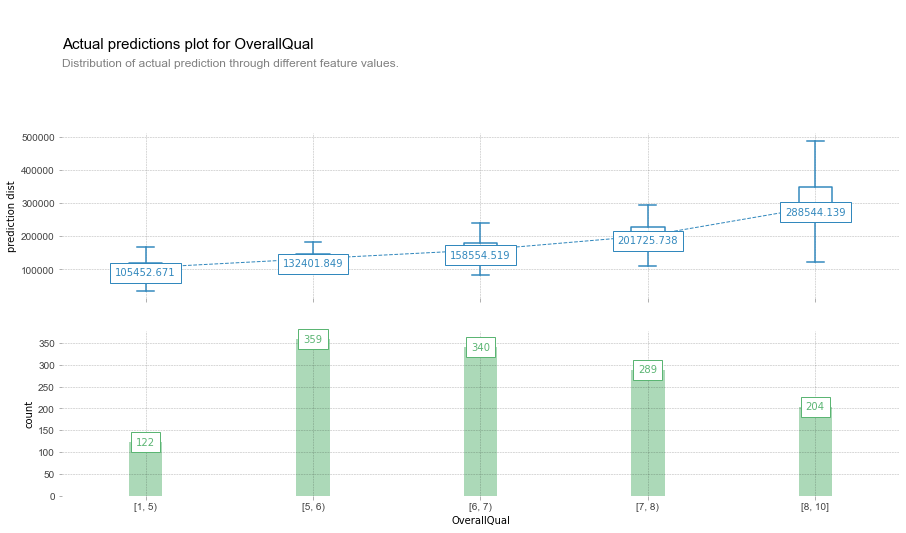

In [20]:
# this chart summarizes the model predictions made for each unique value in the day_of_week column
fig, axes, summary_df = info_plots.actual_plot(
    # notice these options -- accesing the appropriate parts of our pipeline to get the data setup
    # For X we are passing in what our model will use to predict; which is why we need to transform X_train
    model=pipe_final[2], X=pipe_final[1].transform(pipe_final[0].transform(X_train_final)), 
    feature='OverallQual', feature_name='OverallQual', predict_kwds={}
)

# this is just to get the tick marks to render correctly on the bottom
#_ = axes['bar_ax'].set_xticklabels(['Monday', 'Tuesday', 'Thursday', 'Wednesday', 'Friday', 'Sunday', 'Saturday'])

In [21]:
summary_df

,x,display_column,value_lower,value_upper,count,actual_prediction_q1,actual_prediction_q2,actual_prediction_q3
0,0,"[1, 5)",1.0,5.0,122,83030.233710,105452.671375,118453.361274
1,1,"[5, 6)",5.0,6.0,359,120828.404877,132401.848960,145371.653195
2,2,"[6, 7)",6.0,7.0,340,139406.924602,158554.519118,179339.126375
3,3,"[7, 8)",7.0,8.0,289,180844.367472,201725.738266,229245.048196
4,4,"[8, 10]",8.0,10.0,204,253688.513609,288544.138944,347394.466734


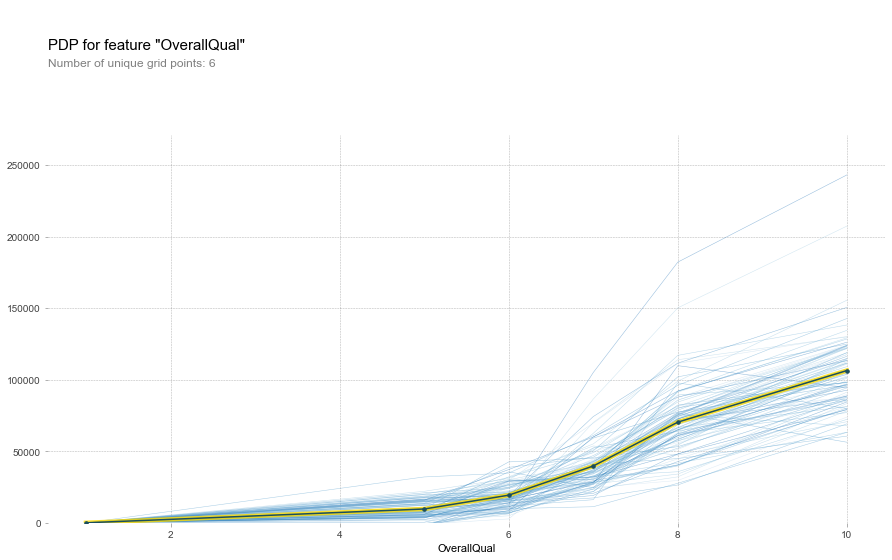

In [30]:
# what was the additive impact of EACH unique value of OverallQual?  What was its marginal impact?
pdp_OverallQual = pdp.pdp_isolate(
    model=pipe_final[2], 
    dataset=pipe_final[1].transform(pipe_final[0].transform(X_train_final)), 
    model_features=X_train_final.columns.tolist(), 
    feature='OverallQual'
)
fig, axes = pdp.pdp_plot(pdp_OverallQual, 'OverallQual', plot_lines=True, frac_to_plot=100)

This shows that OverallQual is a particularly strong driver / differentiator once it moves beyond 4-5. Lower values could potentially be bucketed within the model.

## Neighborhood Variable

Look at actuals, to simplify this assessment convert neigborhood to one-hot encoding. Below is an example of output utilising TargetEncoding.

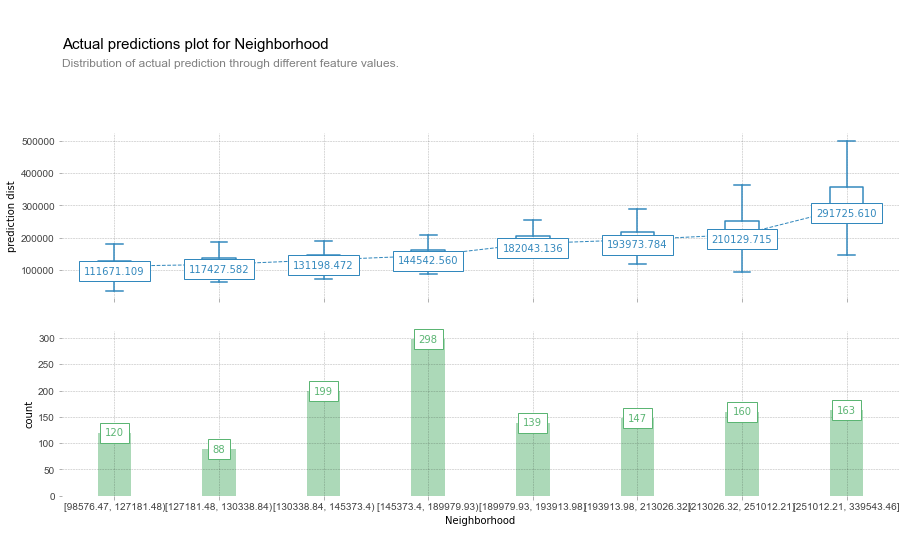

In [35]:
# this chart summarizes the model predictions made for each unique value in the day_of_week column
fig, axes, summary_df = info_plots.actual_plot(
    # notice these options -- accesing the appropriate parts of our pipeline to get the data setup
    # For X we are passing in what our model will use to predict; which is why we need to transform X_train
    model=pipe_final[2], X=pipe_final[1].transform(pipe_final[0].transform(X_train_final)), 
    feature='Neighborhood', feature_name='Neighborhood', predict_kwds={}
)

# this is just to get the tick marks to render correctly on the bottom
#_ = axes['bar_ax'].set_xticklabels(['Monday', 'Tuesday', 'Thursday', 'Wednesday', 'Friday', 'Sunday', 'Saturday'])

In [38]:
onehot_enc_cols = [
    'Neighborhood',
]
onehot_enc = ce.OneHotEncoder(verbose=1,cols=targ_enc_cols,use_cat_names=True)

ordenc_cols = [
'KitchenQual',
]

ordenc_maps = [
{'col':'KitchenQual', 'mapping':{'NA':0,'Ex':1,'Gd':2,'TA':3,'Fa':4,'Po':5,}},
]

ordinal_enc2 = ce.OrdinalEncoder(cols=ordenc_cols,mapping=ordenc_maps,verbose=1)

gbm_final = GradientBoostingRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_leaf_nodes=None,
    max_depth=5,
    min_samples_leaf=1)

pipe_ohc = make_pipeline(onehot_enc,ordinal_enc2,gbm_final)


In [39]:
pipe_ohc.fit(X_train_final,y_train_final)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Neighborhood'], use_cat_names=True,
                               verbose=1)),
                ('ordinalencoder',
                 OrdinalEncoder(cols=['KitchenQual'],
                                mapping=[{'col': 'KitchenQual',
                                          'mapping': {'Ex': 1, 'Fa': 4, 'Gd': 2,
                                                      'NA': 0, 'Po': 5,
                                                      'TA': 3}}],
                                verbose=1)),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(learning_rate=0.05, max_depth=5,
                                           n_estimators=400))])

In [51]:
pipe_ohc.score(X_test_final,y_test_final)
# Interestingly one hot encoding improves it from 0.865 to 0.884; a minor uplift on the training data set.

0.8837583199103942

In [45]:
neighborhood_cols = [col for col in pipe_ohc[0].get_feature_names() if 'Neighborhood' in col]
neighborhood_cols

['Neighborhood_BrkSide',
 'Neighborhood_Somerst',
 'Neighborhood_OldTown',
 'Neighborhood_ClearCr',
 'Neighborhood_Edwards',
 'Neighborhood_Gilbert',
 'Neighborhood_IDOTRR',
 'Neighborhood_Mitchel',
 'Neighborhood_Crawfor',
 'Neighborhood_NAmes',
 'Neighborhood_MeadowV',
 'Neighborhood_SWISU',
 'Neighborhood_SawyerW',
 'Neighborhood_StoneBr',
 'Neighborhood_NridgHt',
 'Neighborhood_Sawyer',
 'Neighborhood_NoRidge',
 'Neighborhood_NPkVill',
 'Neighborhood_Timber',
 'Neighborhood_CollgCr',
 'Neighborhood_NWAmes',
 'Neighborhood_Veenker',
 'Neighborhood_Blmngtn',
 'Neighborhood_BrDale',
 'Neighborhood_Blueste']

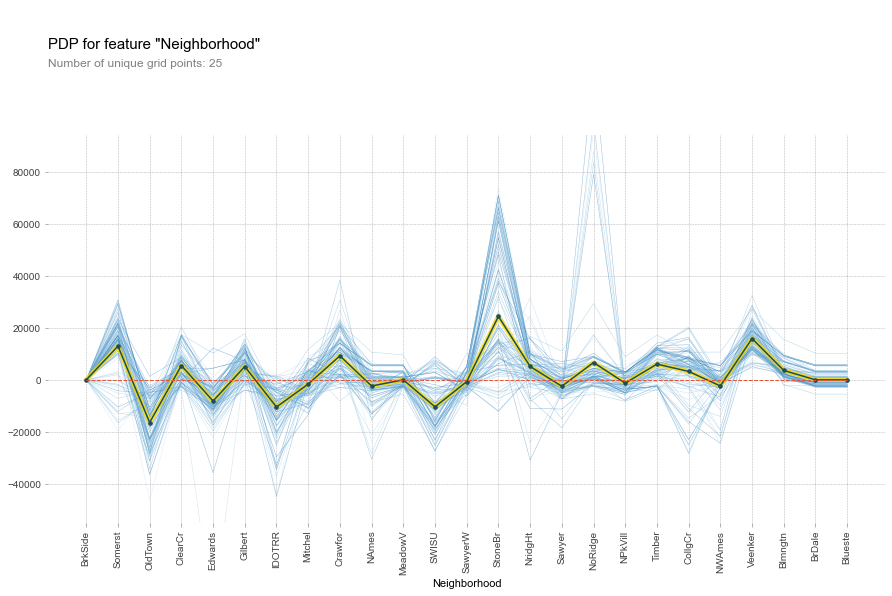

In [50]:
pdp_neighborhood = pdp.pdp_isolate(
    model=pipe_ohc[2], 
    # dataset -- create the final transformation of our data
    dataset=pipe_ohc[1].transform(pipe_ohc[0].transform(X_train_final)), 
    # All features in the model
    model_features=pipe_ohc[1].get_feature_names(), 
    # this is the list of all the columns for the genre feature
    feature=neighborhood_cols
)

fig, axes = pdp.pdp_plot(pdp_neighborhood, 'Neighborhood', plot_lines=True, frac_to_plot=100)
# this code is just for formatting -- getting the labels to format correctly
xtick_labels = [n.split('_')[1] for n in neighborhood_cols]
axes['pdp_ax'].set_xticklabels(xtick_labels, rotation='vertical');

Overall there are definitely strong neighborhood effects visible in the neihborhood plot, and while there are consistently some cases that are outside the mix, this explains why neighborhood only has a partial, and quite variable influence.

## Overall Partial Dependency Comments  

* Here partial dependency is somewhat useful
    * It shows the generally strong positive relationship between OverallQual and SalePrice
    * It shows the widely fluctuating relationship between different neighborhood's andSalePrice

* The icelines for neighborhood are particularly interesting in that they show that Veenker has a much more consistent mix of house prices than Stone Brook or Northridge (which appears to have some very expensive properties relative to other parts of town in a few specific cases).